In [1]:
## import python modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
import datetime as dt


%matplotlib inline

We will use precipitation and column relative humidity to characterize the environment of tropical cyclones as identified by the TempestExtremes Algorithm. The data is spaced 6 hours apart with a horizontal resolution of $\sim$ 0.25 deg. 

In [369]:
# set paths to read crh and precipitation data

In [370]:
thermo_path='/neelin2020/ERA-5_cwv_That/era5_cwv_that_'
precip_path='/neelin2020/TRMM_3B42/TRMM.3hrly.3B42.'


class hurricane reads year and extracts number of TCs, and related thermodynamic and precipitation fields from ERA5 data

In [395]:
class hurricance:
    
    def __init__(self,year,paths):
        self.year=year
        self.thermo_path=paths[0]
        self.precip_path=paths[1]
        self.offset=7.5 ## box size in deg. lat/lon around feature center
        
    def __extract_dates(self,date_array):
        dates=[]
        for n in range(date_array.shape[0]):
            yr,mo,dy,hr=np.int_(date_array[n])
            dates.append(dt.datetime(yr,mo,dy,hr))
        
        return dates    
    
    def extract_tracks(self):
        
        ### read Tempest Extremes Tracks for ERA-5
        fili='/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_20200824.txt'
        
        f=open(fili,'r')
        lines = f.readlines()    # Read file and close
        f.close()

        i=0
        self.tc_tracks={}
        ctr=0
        while (i < (len(lines)-1) ):
            line = lines[i]
            i = i+1
            linesplit = line.strip().split('\t')
            if linesplit[0] == 'start' :
                tracklength = int(linesplit[1])
                trackarray = np.genfromtxt(lines[i:(i+tracklength)])
                dates=self.__extract_dates(np.int_(trackarray[:,-4:]))
                lon=trackarray[:,2]
                lat=trackarray[:,3]
                psl=trackarray[:,4]*1e-2 ### in hPa
                max_wind=trackarray[:,5]
                
        #         if(np.logical_and(dates[0].year>start_year, dates[-1].year<=end_year)): ## for start and end years
                if(dates[0].year==self.year & dates[-1].year==self.year):
                    self.tc_tracks[ctr]={}
                    self.tc_tracks[ctr]['lat']=lat
                    self.tc_tracks[ctr]['lon']=lon
                    self.tc_tracks[ctr]['dates']=dates
                    self.tc_tracks[ctr]['psl']=psl
                    self.tc_tracks[ctr]['maxwind']=max_wind
                    ctr+=1
                    
        print('There are {:d} Tropical Cyclones in {:d}'.format(ctr+1,self.year))
        
    def read_data(self):
        
        '''
        This is the function that reads the precipitation and thermo 
        fields from the ERA5 product.
        '''
        
        self.ds_comp={}
        
        for key in self.tc_tracks.keys():

            fil_era5=glob.glob(self.thermo_path+'2002_01_01.nc')[0]
            ds_thermo=xr.open_dataset(fil_era5)
            ds_thermo.close()
            
            dates=self.tc_tracks[key]['dates']
            
            nan_array=np.zeros((len(dates),ds_thermo.lat.size,ds_thermo.lon.size))
            nan_array[:]=np.nan    
                
            
            self.ds_comp[key] = xr.Dataset(
                data_vars=dict(
                    crh=(["time","lat", "lon"], nan_array.copy()),
#                     That=(["time","lat", "lon"], nan_array.copy()),
                    precipitation=(["time","lat", "lon"], nan_array.copy()),
                ),
                coords=dict(
                    lon=(ds_thermo.lon),
                    lat=(ds_thermo.lat),
                    time=dates,
                ))
            
                                    
            for i,j,k in zip(self.tc_tracks[key]['lat'],self.tc_tracks[key]['lon'],self.tc_tracks[key]['dates']):
                try:
                    fil_era5=glob.glob(self.thermo_path+dt.datetime.strftime(k,'%Y_%m_%d')+'.nc')[0]
                    fil_precip=glob.glob(self.precip_path+dt.datetime.strftime(k,'%Y%m*')+'.nc')[0]
                except:
#                     print('Files not found')
                    break
                

                ### extract lat, lon ranges for each date ###
                ds_thermo=xr.open_dataset(fil_era5)
                ds_precip=xr.open_dataset(fil_precip)
                ds_precip=ds_precip.rename({'latitude':'lat',
                                          'longitude':'lon'})
                
                la=ds_thermo.lat
                lc=ds_thermo.lon

                loc_dict=dict(lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                loc_dict_time=dict(time=k,
                                   lat=la[(la>=i-self.offset) & (la<=i+self.offset)],
                       lon=lc[(lc>=j-self.offset) & (lc<=j+self.offset)])

                
                if len(loc_dict['lat'])==0:
#                     print('Latitude out of bounds')
                    break

                cwv=ds_thermo.cwv.sel(time=k,method='nearest').loc[loc_dict]
                cwv_sat=ds_thermo.cwv_sat.sel(time=k,method='nearest').loc[loc_dict]
                crh_inst=cwv/cwv_sat
                self.ds_comp[key]['crh'].loc[loc_dict_time]=crh_inst

                prc_inst=ds_precip.precip_trmm.sel(time=k,method='nearest').loc[loc_dict]
                self.ds_comp[key]['precipitation'].loc[loc_dict_time]=prc_inst

                ds_thermo.close()
                ds_precip.close()
            
            self.ds_comp[key].close()
            print(key, 'Max wind: {:.2f} m/s, Min psl: {:.2f} hPa'.format(max(self.tc_tracks[key]['maxwind']),
                 min(self.tc_tracks[key]['psl'])))


In [396]:
### read 
year=2002 ## enter year here. We have years 2002-2014 processed
tcs=hurricance(year,[thermo_path,precip_path])
tcs.extract_tracks()  
tcs.read_data()


There are 67 Tropical Cyclones in 2002
0 Max wind: 20.67 m/s, Min psl: 991.68 hPa
1 Max wind: 18.77 m/s, Min psl: 1001.42 hPa
2 Max wind: 32.26 m/s, Min psl: 958.80 hPa
3 Max wind: 21.83 m/s, Min psl: 988.46 hPa
4 Max wind: 26.17 m/s, Min psl: 973.45 hPa
5 Max wind: 26.84 m/s, Min psl: 967.53 hPa
6 Max wind: 20.38 m/s, Min psl: 984.45 hPa
7 Max wind: 22.33 m/s, Min psl: 993.53 hPa
8 Max wind: 26.38 m/s, Min psl: 978.93 hPa
9 Max wind: 26.99 m/s, Min psl: 955.22 hPa
10 Max wind: 20.68 m/s, Min psl: 997.71 hPa
11 Max wind: 25.98 m/s, Min psl: 985.69 hPa
12 Max wind: 27.86 m/s, Min psl: 986.77 hPa
13 Max wind: 18.83 m/s, Min psl: 999.96 hPa
14 Max wind: 19.93 m/s, Min psl: 988.39 hPa
15 Max wind: 19.02 m/s, Min psl: 995.80 hPa
16 Max wind: 20.48 m/s, Min psl: 978.60 hPa
17 Max wind: 15.85 m/s, Min psl: 1002.69 hPa
18 Max wind: 25.50 m/s, Min psl: 966.47 hPa
19 Max wind: 18.94 m/s, Min psl: 995.60 hPa
20 Max wind: 21.60 m/s, Min psl: 993.05 hPa
21 Max wind: 14.89 m/s, Min psl: 1004.74 hPa


From above, use the max wind near storm center and min sea level pressure to get a gauge of TC intensity.
Select a tc by a number to view its properties and statistics

## Plot

In [397]:
### Create colorbar for precipitation ###

nws_precip_colors = [
#     "#04e9e7",  # 0.01 - 0.10 inches
#     "#019ff4",  # 0.10 - 0.25 inches
#     "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
#     "#f800fd",  # 6.00 - 8.00 inches
#     "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

levels_prc=np.arange(0.0,5.0,0.5)
prc_norm = matplotlib.colors.BoundaryNorm(levels_prc, precip_colormap.N)

In [398]:
def plot_tc_var(ax,var_comp,lon_array,lat_array,cmap,norm,
                plot_params):
    
    ax.coastlines()
    CT=ax.pcolormesh(var_comp.lon,var_comp.lat,var_comp,cmap=cmap,
                   norm=norm,transform=ccrs.PlateCarree())


    if plot_params['TRACKS_ON']:
        
        
        ax.scatter(lon_array, lat_array, s=sizes, c=plot_params['colors'],  
           alpha=0.5, transform=ccrs.PlateCarree())  # Plot

    
        ax.scatter(lon_array[0], lat_array[0], s=plot_params['sizes'].max()*2.0, 
                   c='black', marker='^',alpha=1.0, 
                   transform=ccrs.PlateCarree())  # Plot

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_aspect('auto')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False

    gl.xlines = True
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90,10))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    ax.set_title('{:s}'.format(plot_params['title']),
                 fontsize=15)

    
    if plot_params['CB_ON']:

        ### insert colorbar ###

        axpos = ax.get_position()
        pos_x = axpos.x0#+axpos.width + 0.025# + 0.25*axpos.width
        pos_y = axpos.y0-axpos.height*0.2
        cax_width = axpos.width
        cax_height = axpos.height*0.025

        #create new axes where the colorbar should go.
        #it should be next to the original axes and have the same height!

        
        
        pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
        cb=plt.colorbar(CT, cax=pos_cax,label=plot_params['cb_title'],format='%.1f',
                     orientation='horizontal')
        font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
        pos_cax.xaxis.label.set_font_properties(font)
        pos_cax.tick_params(which='both',labelsize=12.)

        tick_locator = mticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        
def bin_precip_crh(crh,precip):
    x,y=crh.values.flatten(),precip.values.flatten()
    
    y=y[np.isfinite(x)]
    x=x[np.isfinite(x)]
    
    crh_indx=np.int_((x-crh_bins[0])/np.diff(crh_bins)[0])
    prc_binned=np.zeros_like(crh_bins)
    crh_hist=np.zeros_like(crh_bins)
    crh_std=np.zeros_like(crh_bins)

    for i in np.arange(crh_bins.size):
        indx=np.where(crh_indx==i)
        prc_binned[i]=y[indx].mean()
        crh_hist[i]=indx[0].size
        crh_std[i]=y[indx].std()/np.sqrt(crh_hist[i])
    crh_hist=crh_hist/(crh_hist.sum()*np.diff(crh_bins)[0])
        
    return prc_binned,crh_std,crh_hist

In [401]:
## set plot parameters
tc_number=50

lon_array=tcs.tc_tracks[tc_number]['lon']
lat_array=tcs.tc_tracks[tc_number]['lat']
sizes=tcs.tc_tracks[tc_number]['psl'].copy()
sizes/=sizes.max()
sizes*=50

colors = cm.Reds(np.linspace(0, 1, sizes.size))#[np.int_(tc[key].sss+5)-1]
cmap_cwv=plt.get_cmap('YlGnBu')
cmap_That=plt.get_cmap('YlOrRd')


levels_cwv=np.arange(20.,67.5,2.5)
levels_crh=np.arange(0.5,.95,0.025)

levels_That=np.arange(269.,273.,1.0)

# levels_subsat=np.arange(0.,.75,0.025)

extent=[lon_array.min()-10,lon_array.max()+10,
        lat_array.min()-10,lat_array.max()+10]

crh_comp=tcs.ds_comp[tc_number].crh.mean('time')
# That_comp=tcs.ds_comp[tc_number].That.mean('time')
prc_comp=tcs.ds_comp[tc_number].precipitation.mean('time')

prc_comp=prc_comp.where(prc_comp>0)

plot_params={}
plot_params['sizes']=sizes
plot_params['levels_cwv']=levels_cwv
plot_params['levels_cwv']=extent
plot_params['colors']=colors
plot_params['CB_ON']=True
plot_params['TRACKS_ON']=True

crh_bins=np.arange(0.2,1.1,0.05)
prc_binned,crh_std,crh_hist=bin_precip_crh(tcs.ds_comp[tc_number].crh,
                   tcs.ds_comp[tc_number].precipitation)

<ipython-input-398-110c78e2e12f>:75: RuntimeWarning: Mean of empty slice.
  prc_binned[i]=y[indx].mean()
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ipython-input-402-dfb57dce1fa2>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-402-dfb57dce1fa2>:44: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


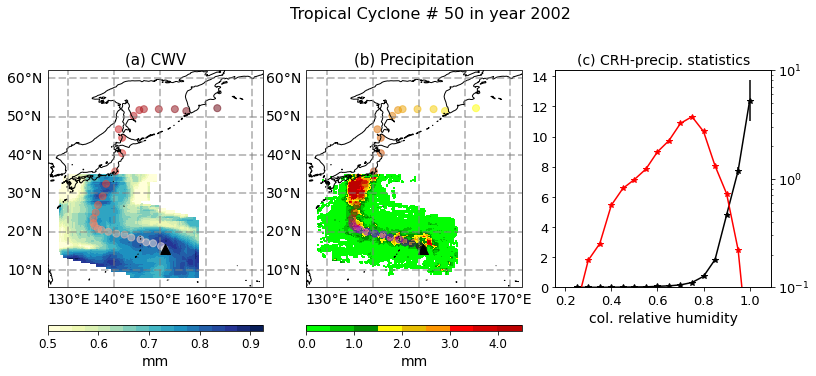

In [402]:
plot_params['title']='(a) CWV'
plot_params['cb_title']='mm'

fig,axx = plt.subplots(1,2,figsize=(8.5, 4),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

norm = BoundaryNorm(levels_crh, ncolors=cmap_cwv.N, clip=True)

ax=axx[0]
plot_tc_var(ax,crh_comp,lon_array,lat_array,cmap_cwv,norm,
                plot_params)

# plot_params['title']='(b) $\hat{T}$'
# plot_params['cb_title']='K'

# norm = BoundaryNorm(levels_That, ncolors=cmap_That.N, clip=True)
ax=axx[1]
plot_params['colors'] = cm.gnuplot(np.linspace(0, 1, sizes.size))#[np.int_(tc[key].sss+5)-1]
plot_params['title']='(b) Precipitation'
plot_tc_var(ax,prc_comp,lon_array,lat_array,precip_colormap,prc_norm,
                plot_params)



axpos = ax.get_position()
pos_x = axpos.x0*1.1#+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = axpos.width
cax_height = axpos.height

ax = fig.add_axes([pos_x+cax_width,pos_y,cax_width,cax_height])

ax.errorbar(crh_bins,prc_binned,crh_std,color='black',marker='*')
ax2=ax.twinx()
ax2.plot(crh_bins,crh_hist,color='red',marker='*')
ax.set_ylim(bottom=0)
ax.tick_params(which='both',labelsize=13)
ax2.tick_params(which='both',labelsize=13)
ax2.set_yscale('log')
ax2.set_ylim(top=1e1,bottom=1e-1)
ax.set_xlabel('col. relative humidity',fontsize=14)
ax.set_title('(c) CRH-precip. statistics',fontsize=14)

plt.tight_layout()
plt.suptitle('Tropical Cyclone # {:d} in year {:d}'.format(tc_number,year),fontsize=16,
             y=1.1,x=.75)

SAVE=False
if SAVE:
    ### Enter save directory here ###
    plt_name='/home/fiaz/NOAA_MDTF_Proposal_Related/plots/ERA5_TE_tc_{:d}_{:03d}.jpg'.format(year,tc_number)
    plt.savefig(plt_name,format='jpg',dpi=100,bbox_inches='tight')
    print("Plot saved to {:s}".format(plt_name))


<ipython-input-403-7106fd0d2cc5>:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


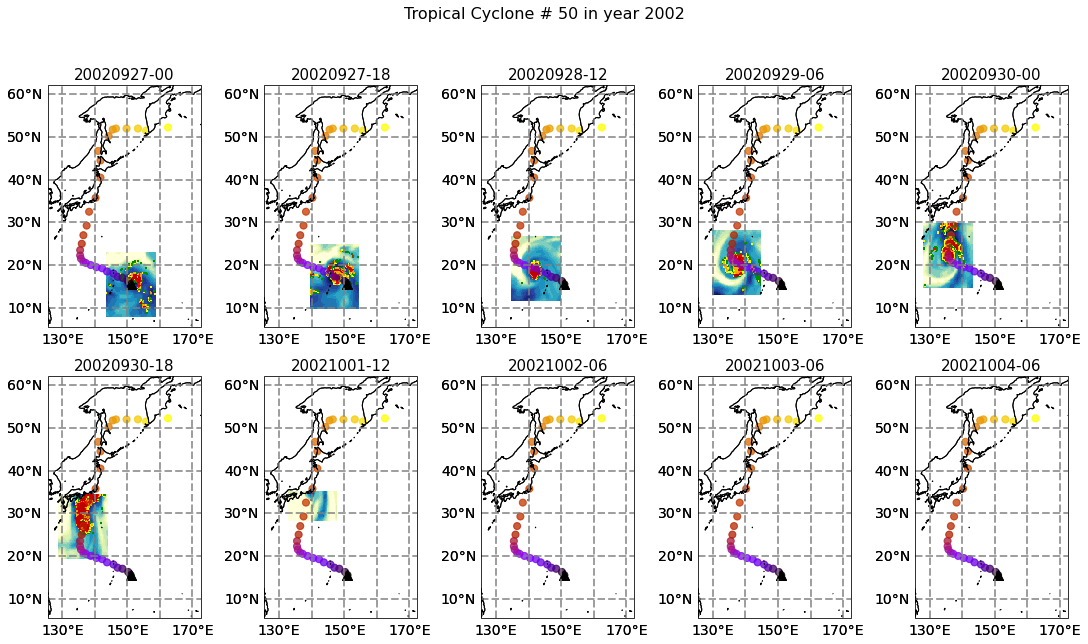

In [403]:
fig,axx = plt.subplots(2,5,figsize=(15, 8),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=True)

plot_params['TRACKS_ON']=True
plot_params['CB_ON']=False

for i,j in enumerate(np.int_(np.linspace(0,tcs.ds_comp[tc_number].precipitation.time.size-1,10))):
    ax=axx[i//5,np.mod(i,5)]
    plot_params['title']=tcs.ds_comp[tc_number].time.dt.strftime("%Y%m%d-%H").isel(time=j).item()
    
    plot_tc_var(ax,tcs.ds_comp[tc_number].crh.isel(time=j),lon_array,lat_array,cmap_cwv,norm,
                plot_params)
    prc=tcs.ds_comp[tc_number].precipitation.isel(time=j)
    prc=prc.where(prc>1.0)
    plot_tc_var(ax,prc,lon_array,lat_array,precip_colormap,prc_norm,
                    plot_params)


plt.tight_layout()
plt.suptitle('Tropical Cyclone # {:d} in year {:d}'.format(tc_number,year),fontsize=16,
         y=1.1)

SAVE=False
if SAVE:
    ### Enter save directory here ###
    plt_name='/home/fiaz/NOAA_MDTF_Proposal_Related/plots/ERA5_TE_tc_snapshots_{:d}_{:03d}.jpg'.format(year,tc_number)
    plt.savefig(plt_name,format='jpg',dpi=100,bbox_inches='tight')
    print("Plot saved to {:s}".format(plt_name))